In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc


In [2]:
import utils
from config import store_dir, data_dir, date_key
%load_ext autoreload
%autoreload 2

# Load data

In [3]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )

In [4]:
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )

In [5]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [26]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'], top=10)
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'], top=10)
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'], top=10)
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'], top=10)
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'], top=10)

# Make table with all features and create AnnData object

Make feature list/table 

In [7]:
fdr_cutoff = 0.5

In [8]:
# Get all features

features = []
for tab in tqdm(results.values()):
    tmp_tab = tab[tab['fdr'] <= 0.5]
    for ix in tmp_tab['ion']:
            features.append(ix)
features = list(set(features))

100%|██████████| 7443/7443 [00:06<00:00, 1202.28it/s]


In [9]:
len(features)

77087

In [10]:
# Initialize empty df
fdr_data = pd.DataFrame(0, columns=list(set(features)), index=results.keys(), dtype='float64')

In [11]:
fdr_data.shape

(7443, 77087)

In [12]:
# Fill dataframe
for i in tqdm(results.keys()):
    # It is late, I lost my creativity for variable names
    tmp_tab = results[i][results[i]['fdr'] <= 0.5]
    
    ttt = tmp_tab.reset_index()[['ion', 'intensity']]
    ttt2 = ttt.groupby('ion').sum()
    
    fdr_data.loc[i, ttt2.index] = ttt2['intensity'].values

100%|██████████| 7443/7443 [01:54<00:00, 64.97it/s]


In [27]:
adata = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])

/tmp/ipykernel_86/3986562972.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [28]:
pickle.dump(adata, open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "wb" ))

# Analysis

## All data

In [59]:
adata = pickle.load(open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "rb" ))

In [60]:
sc.pp.filter_genes(adata, min_cells=200)
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.normalize_total(adata, target_sum=1e4)

In [61]:
adata

AnnData object with n_obs × n_vars = 6504 × 9437
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 0, 'n_cells'

In [62]:
sc.pp.neighbors(adata, metric='cosine')

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [63]:
sc.tl.umap(adata)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data f

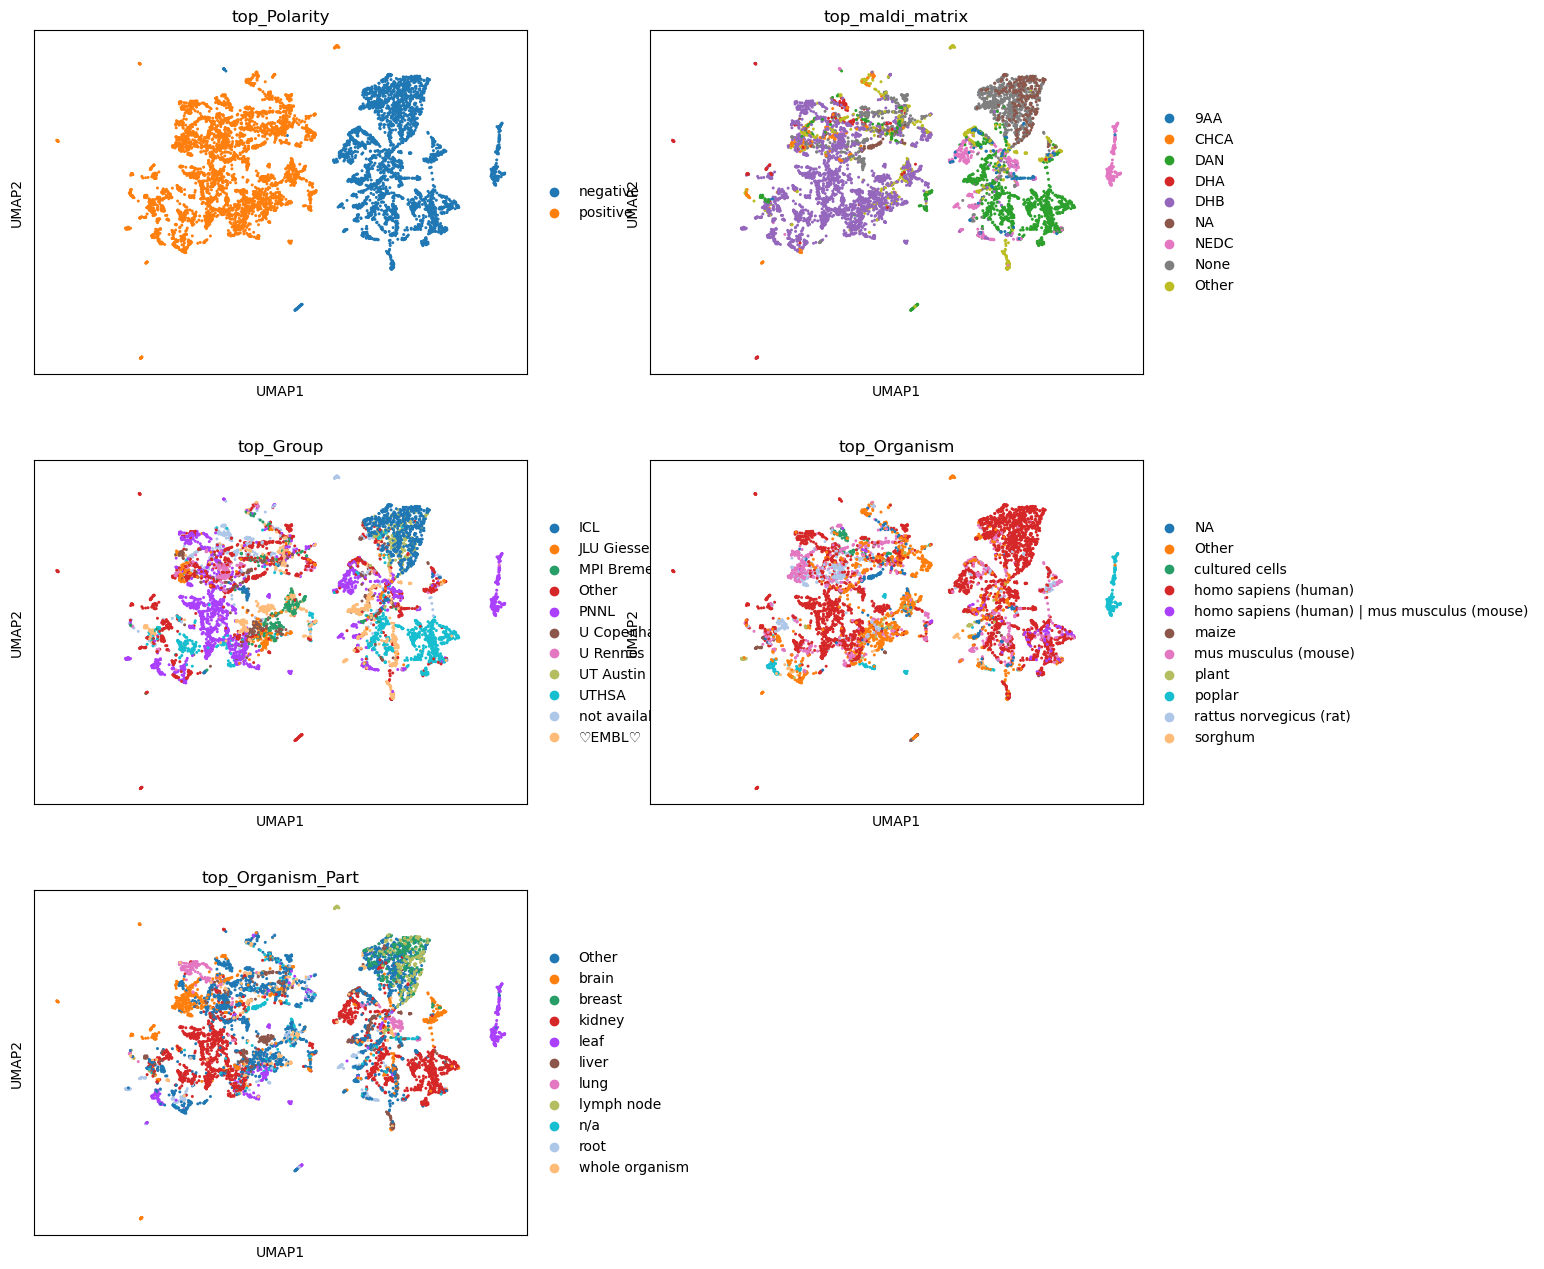

In [64]:
sc.pl.umap(adata, color=['top_Polarity', 'top_maldi_matrix', 'top_Group', 'top_Organism', 'top_Organism_Part'], ncols=2)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data f

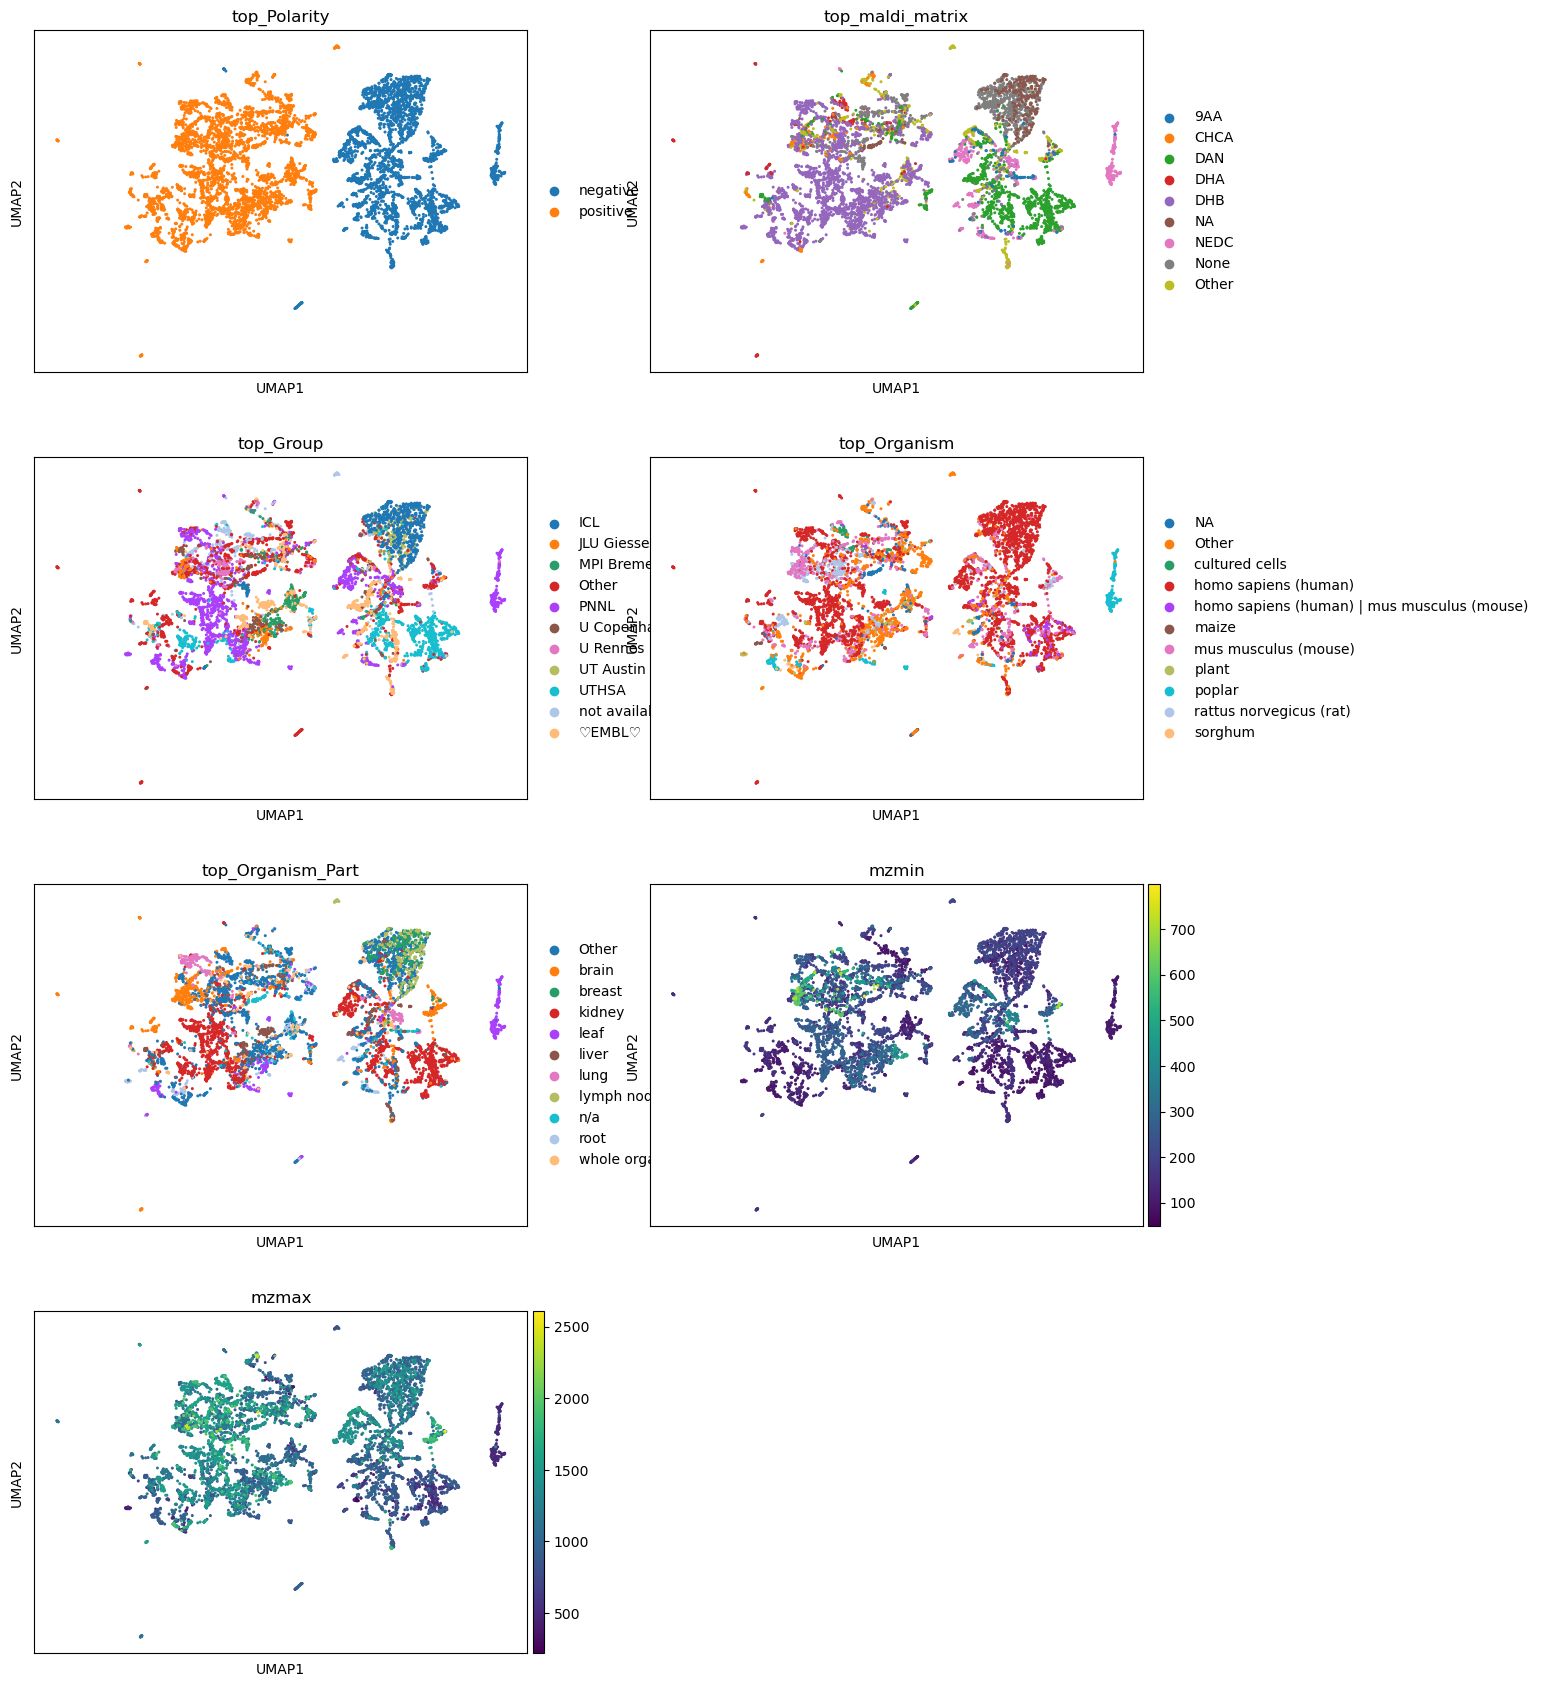

In [65]:
sc.pl.umap(adata, color=['top_Polarity', 'top_maldi_matrix', 'top_Group', 'top_Organism', 'top_Organism_Part', 'mzmin', 'mzmax'], ncols=2)

## Positive

In [34]:
adata_pos = pickle.load(open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "rb" ))

In [35]:
adata_pos = adata_pos[adata_pos.obs['Polarity']=='positive',:]

In [36]:
sc.pp.filter_genes(adata_pos, min_cells=200)
sc.pp.filter_cells(adata_pos, min_genes=50)
sc.pp.normalize_total(adata_pos, target_sum=1e4)
sc.pp.neighbors(adata_pos, metric='cosine')
sc.tl.umap(adata_pos)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


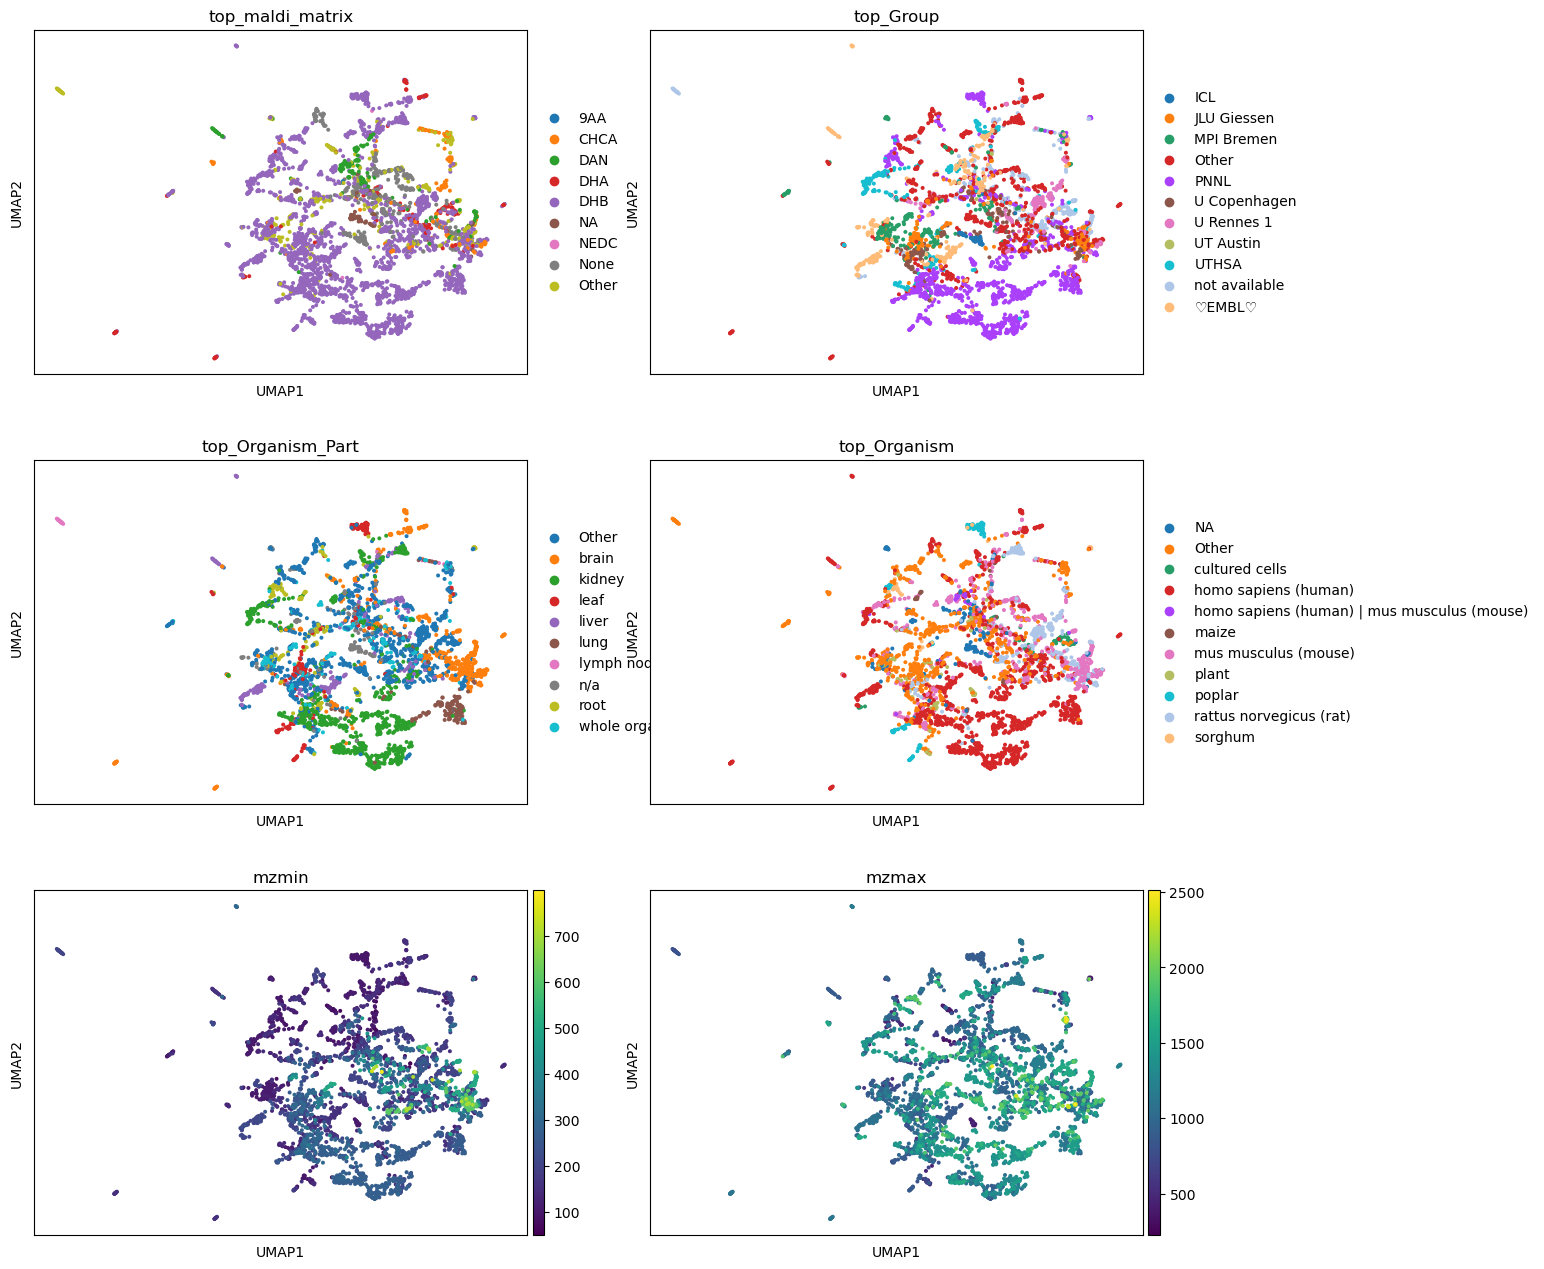

In [66]:
sc.pl.umap(adata_pos, color=['top_maldi_matrix', 'top_Group', 'top_Organism_Part', 'top_Organism', 'mzmin', 'mzmax'], ncols=2)

### BBKNN

In [67]:
adata_pos_bbknn = pickle.load(open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "rb" ))
adata_pos_bbknn = adata_pos_bbknn[adata_pos_bbknn.obs['Polarity']=='positive',:]
sc.pp.filter_genes(adata_pos_bbknn, min_cells=200)
sc.pp.filter_cells(adata_pos_bbknn, min_genes=50)
sc.pp.normalize_total(adata_pos_bbknn, target_sum=1e4)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [82]:
sc.tl.pca(adata_pos_bbknn)
sc.external.pp.bbknn(adata_pos_bbknn, batch_key='maldi_matrix', metric='euclidean', neighbors_within_batch=1)
sc.tl.umap(adata_pos_bbknn)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


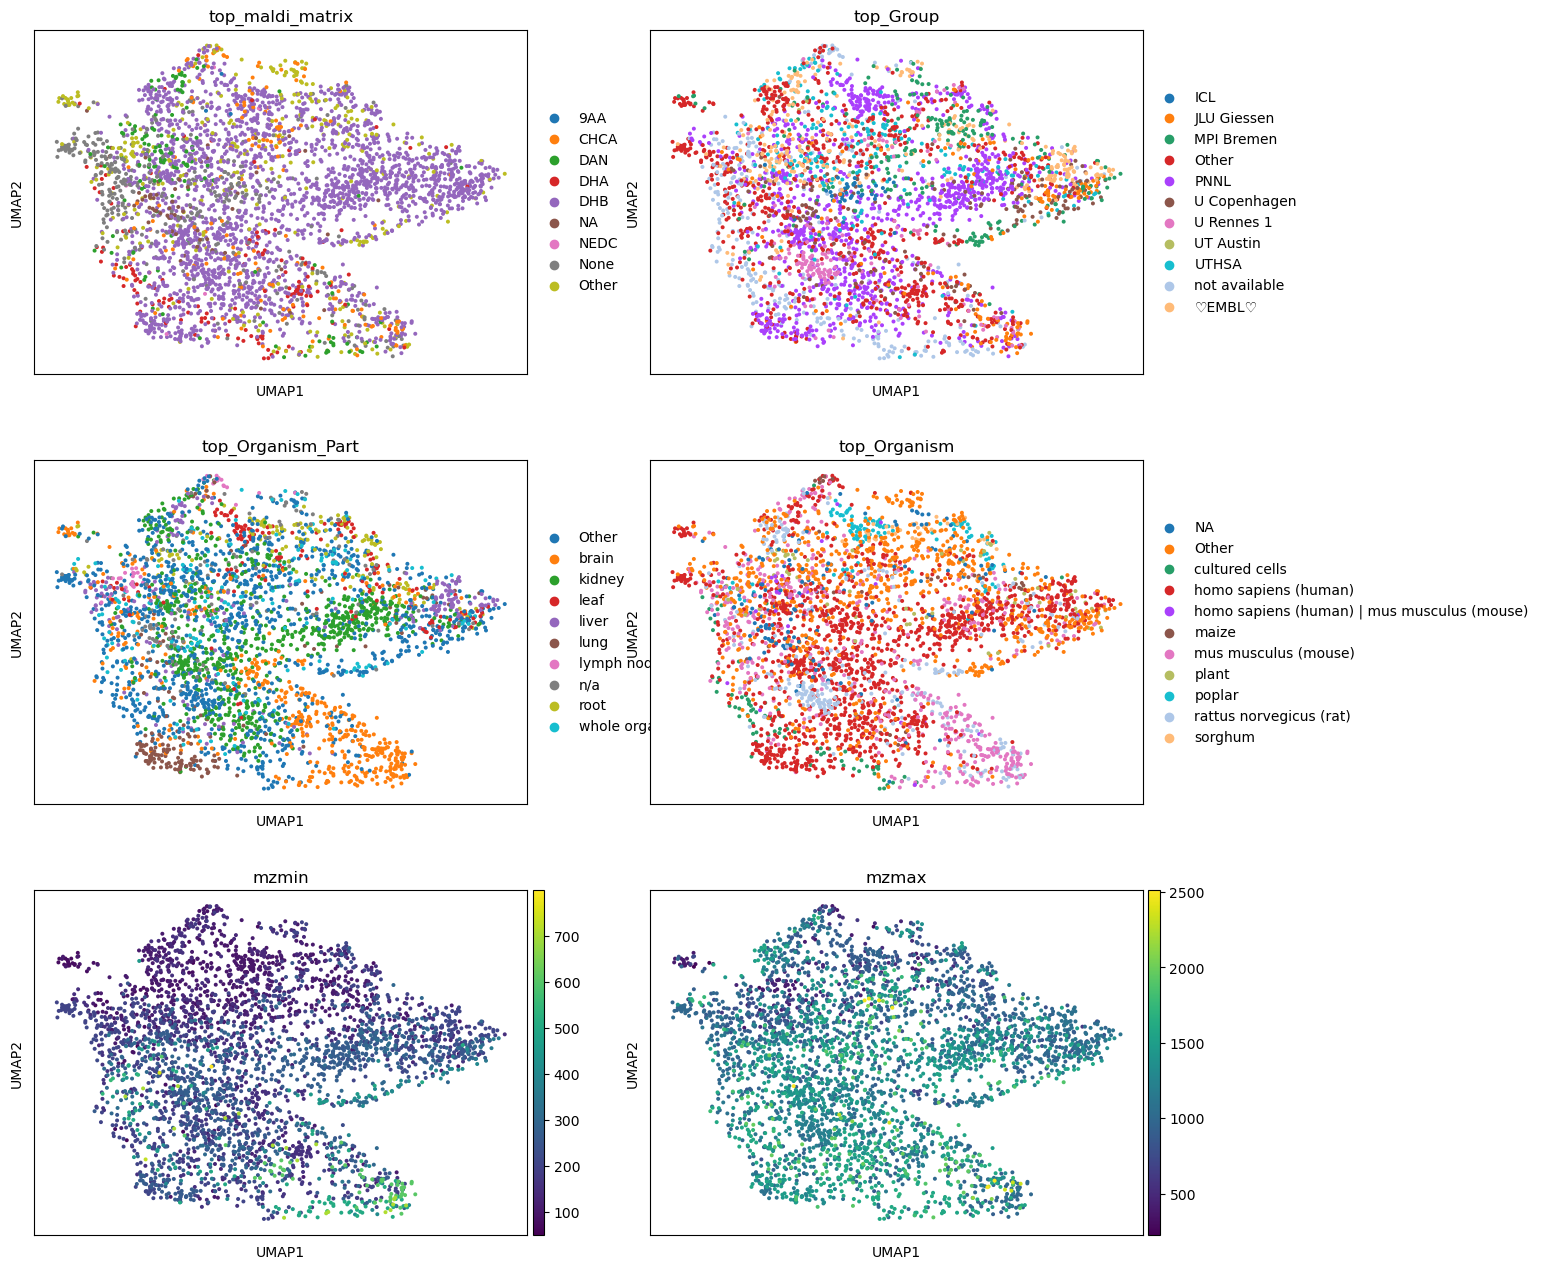

In [83]:
sc.pl.umap(adata_pos_bbknn, color=['top_maldi_matrix', 'top_Group', 'top_Organism_Part', 'top_Organism', 'mzmin', 'mzmax'], ncols=2)

### Harmony

In [85]:
adata_pos_harmony = pickle.load(open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "rb" ))
adata_pos_harmony = adata_pos_harmony[adata_pos_harmony.obs['Polarity']=='positive',:]
sc.pp.filter_genes(adata_pos_harmony, min_cells=200)
sc.pp.filter_cells(adata_pos_harmony, min_genes=50)
sc.pp.normalize_total(adata_pos_harmony, target_sum=1e4)

sc.tl.pca(adata_pos_harmony)

sc.external.pp.harmony_integrate(adata_pos_harmony, 'maldi_matrix')

sc.pp.neighbors(adata_pos_harmony, metric='cosine', use_rep='X_pca_harmony')
sc.tl.umap(adata_pos_harmony)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
2023-02-07 15:23:55,106 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-02-07 15:24:10,654 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-02-07 15:24:10,748 - harmonypy - INFO - Iteration 1 of 10
2023-02-07 15:24:25,050 - harmonypy - INFO - Iteration 2 of 10
2023-02-07 15:24:38,047 - harmonypy - INFO - Iteration 3 of 10
2023-02-07 15:24:50,447 - harmonypy - INFO - Iteration 4 of 10
2023-02-07 15:25:00,860 - harmonypy - INFO - Iteration 5 of 10
2023-02-07 15:25:11,657 - harmonypy - INFO - Iteration 6 of 10
2023-02-07 15:25:21,952 - harmonypy - INFO - Iteration 7 of 10
2023-02-07 15:25:32,744 - harmonypy - INFO - Iteration 8 of 10
2023-02-07 15:25:47,278 - harmonypy - INFO - Iteration 9 of 10
2023-02-07 15:26

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


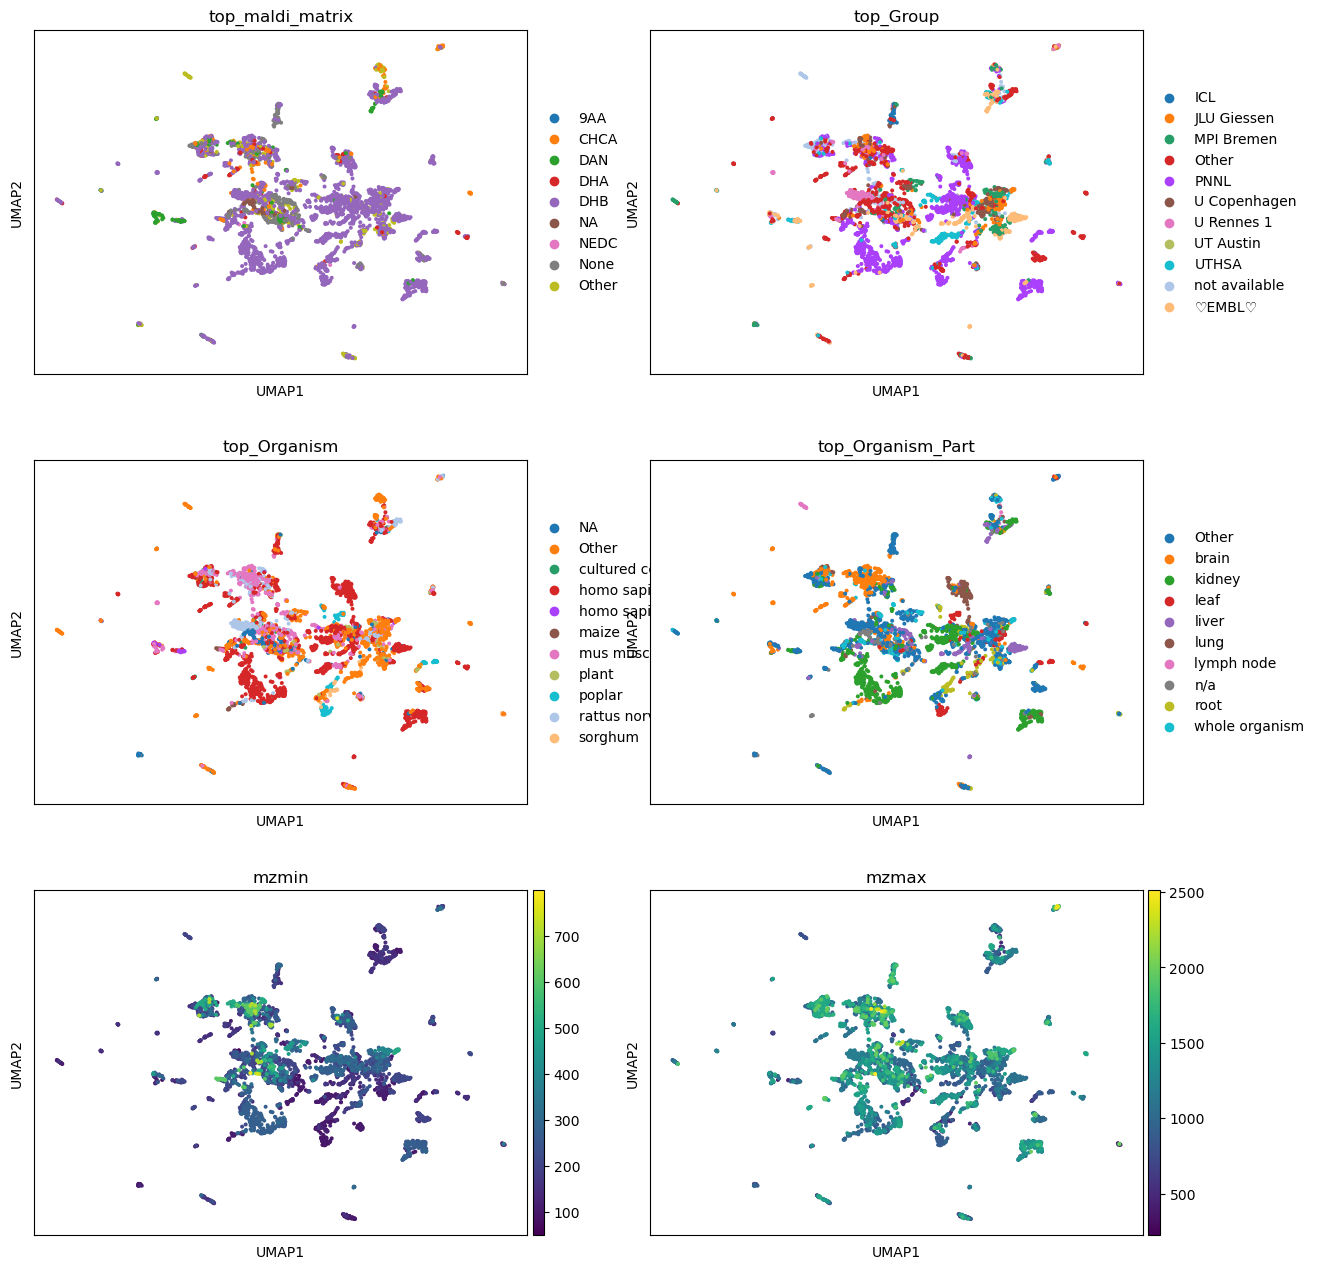

In [86]:
sc.pl.umap(adata_pos_harmony, color=['top_maldi_matrix', 'top_Group', 'top_Organism', 'top_Organism_Part', 'mzmin', 'mzmax'], ncols=2)

## Negative

In [74]:
adata_neg = pickle.load(open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "rb" ))
adata_neg = adata_neg[adata_neg.obs['Polarity']=='negative',:]

In [75]:
sc.pp.filter_genes(adata_neg, min_cells=200)
sc.pp.filter_cells(adata_neg, min_genes=50)
sc.pp.normalize_total(adata_neg, target_sum=1e4)
sc.pp.neighbors(adata_neg, metric='cosine')
sc.tl.umap(adata_neg)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


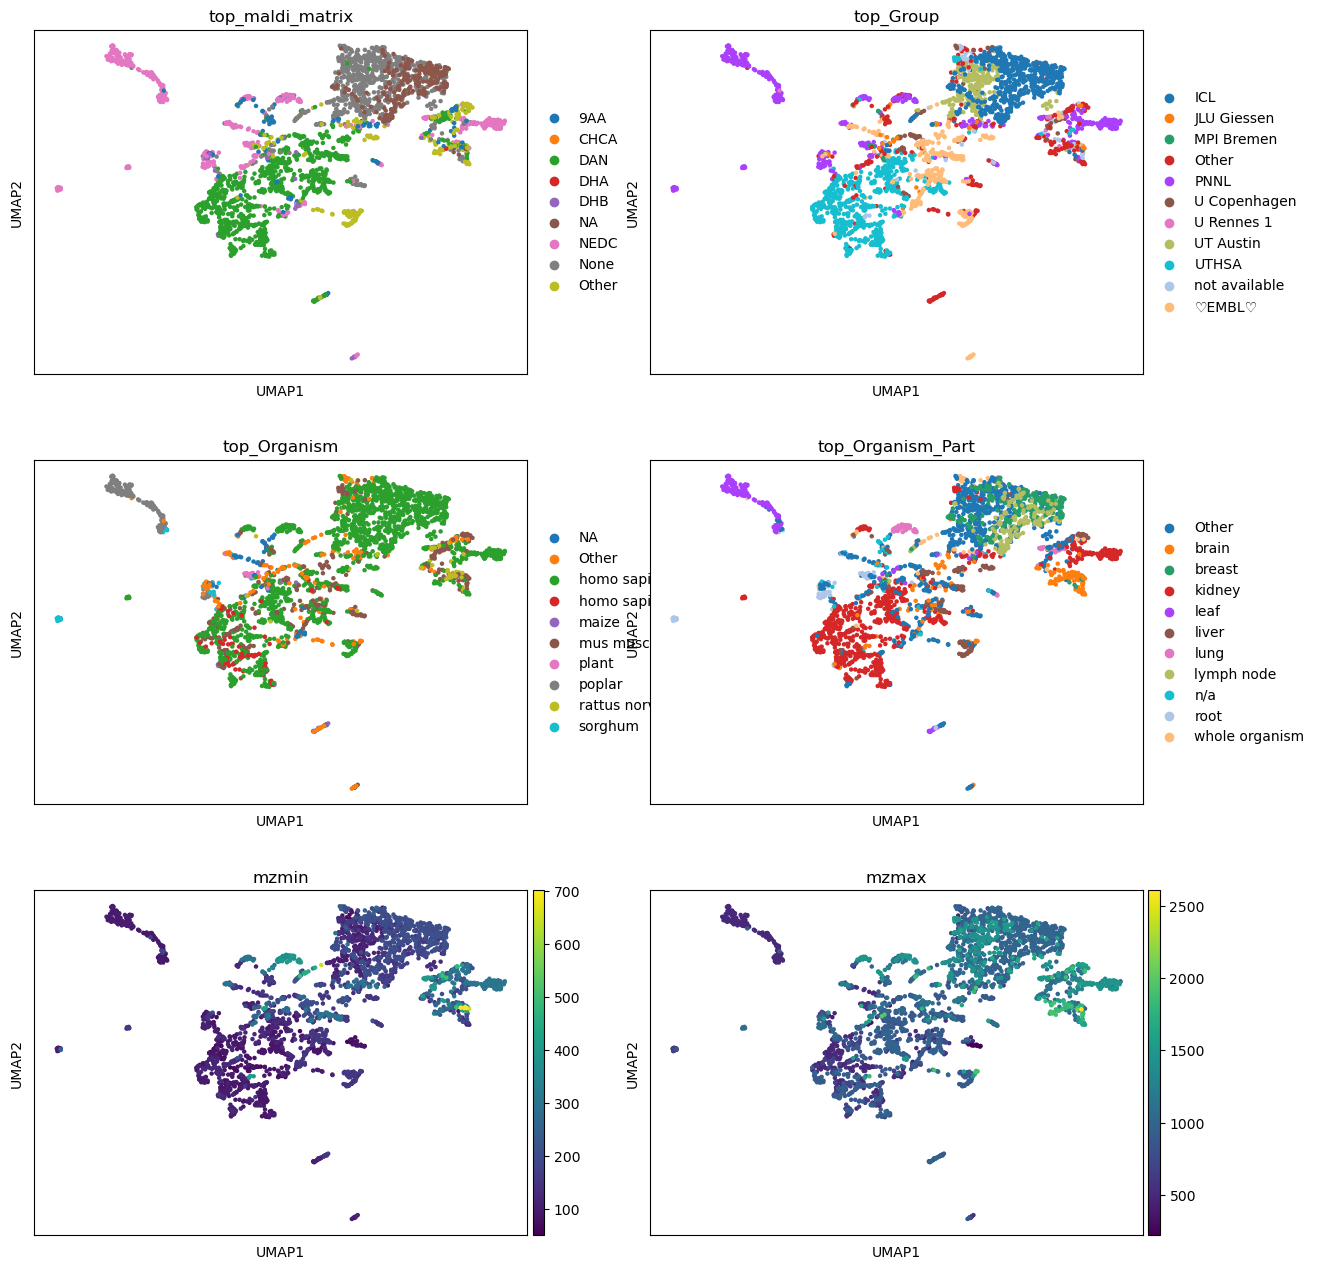

In [77]:
sc.pl.umap(adata_neg, color=['top_maldi_matrix', 'top_Group', 'top_Organism', 'top_Organism_Part', 'mzmin', 'mzmax'], ncols=2)

### BBKNN

In [78]:
adata_neg_bbknn = pickle.load(open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "rb" ))
adata_neg_bbknn = adata_neg_bbknn[adata_neg_bbknn.obs['Polarity']=='negative',:]
sc.pp.filter_genes(adata_neg_bbknn, min_cells=200)
sc.pp.filter_cells(adata_neg_bbknn, min_genes=50)
sc.pp.normalize_total(adata_neg_bbknn, target_sum=1e4)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [79]:
sc.tl.pca(adata_neg_bbknn)
sc.external.pp.bbknn(adata_neg_bbknn, batch_key='maldi_matrix', metric='euclidean', neighbors_within_batch=1)
sc.tl.umap(adata_neg_bbknn)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


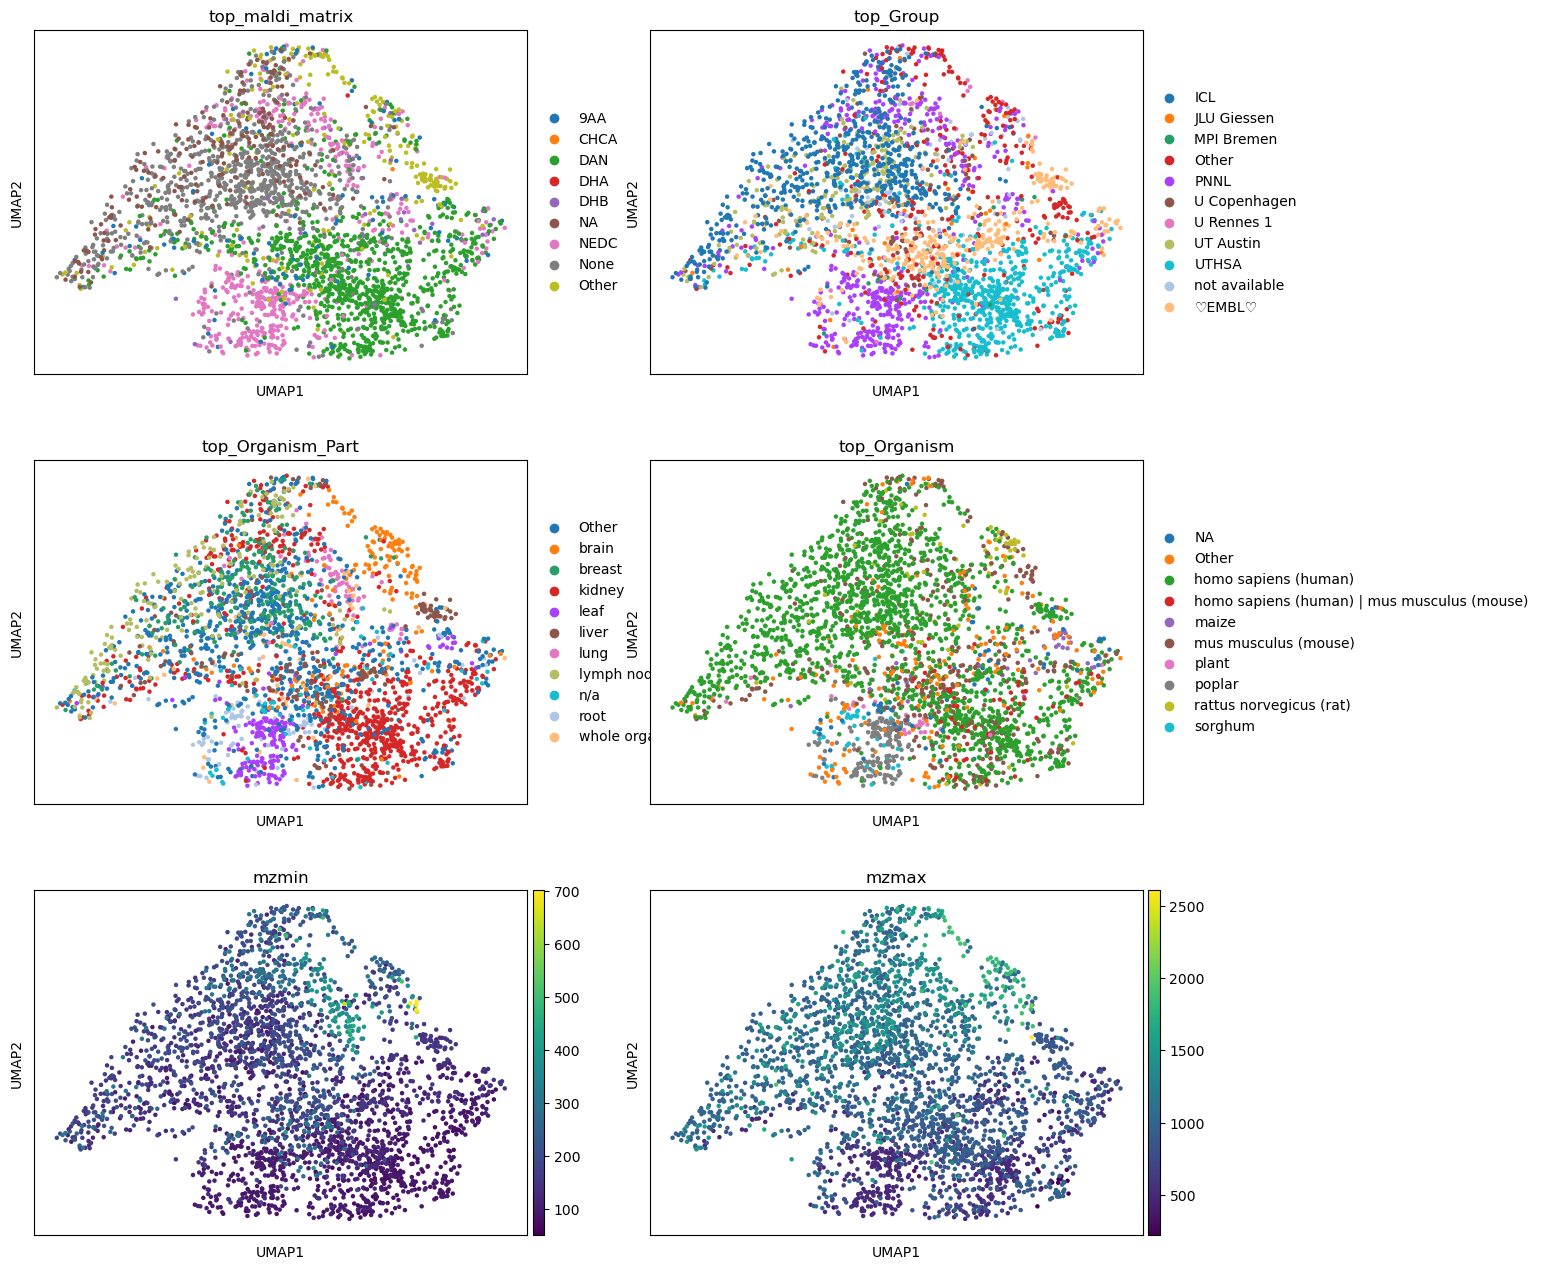

In [80]:
sc.pl.umap(adata_neg_bbknn, color=['top_maldi_matrix', 'top_Group', 'top_Organism_Part', 'top_Organism', 'mzmin', 'mzmax'], ncols=2)

### Harmony

In [87]:
adata_neg_harmony = pickle.load(open( os.path.join(store_dir, 'all_datasets_anndata.pickle'), "rb" ))
adata_neg_harmony = adata_neg_harmony[adata_neg_harmony.obs['Polarity']=='negative',:]
sc.pp.filter_genes(adata_neg_harmony, min_cells=200)
sc.pp.filter_cells(adata_neg_harmony, min_genes=50)
sc.pp.normalize_total(adata_neg_harmony, target_sum=1e4)

sc.tl.pca(adata_neg_harmony)

sc.external.pp.harmony_integrate(adata_neg_harmony, 'maldi_matrix')

sc.pp.neighbors(adata_neg_harmony, metric='cosine', use_rep='X_pca_harmony')
sc.tl.umap(adata_neg_harmony)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
2023-02-07 15:43:57,965 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-02-07 15:44:10,864 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-02-07 15:44:10,960 - harmonypy - INFO - Iteration 1 of 10
2023-02-07 15:44:21,455 - harmonypy - INFO - Iteration 2 of 10
2023-02-07 15:44:31,451 - harmonypy - INFO - Iteration 3 of 10
2023-02-07 15:44:45,946 - harmonypy - INFO - Iteration 4 of 10
2023-02-07 15:45:00,153 - harmonypy - INFO - Iteration 5 of 10
2023-02-07 15:45:10,353 - harmonypy - INFO - Iteration 6 of 10
2023-02-07 15:45:20,754 - harmonypy - INFO - Iteration 7 of 10
2023-02-07 15:45:28,049 - harmonypy - INFO - Converged after 7 iterations


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


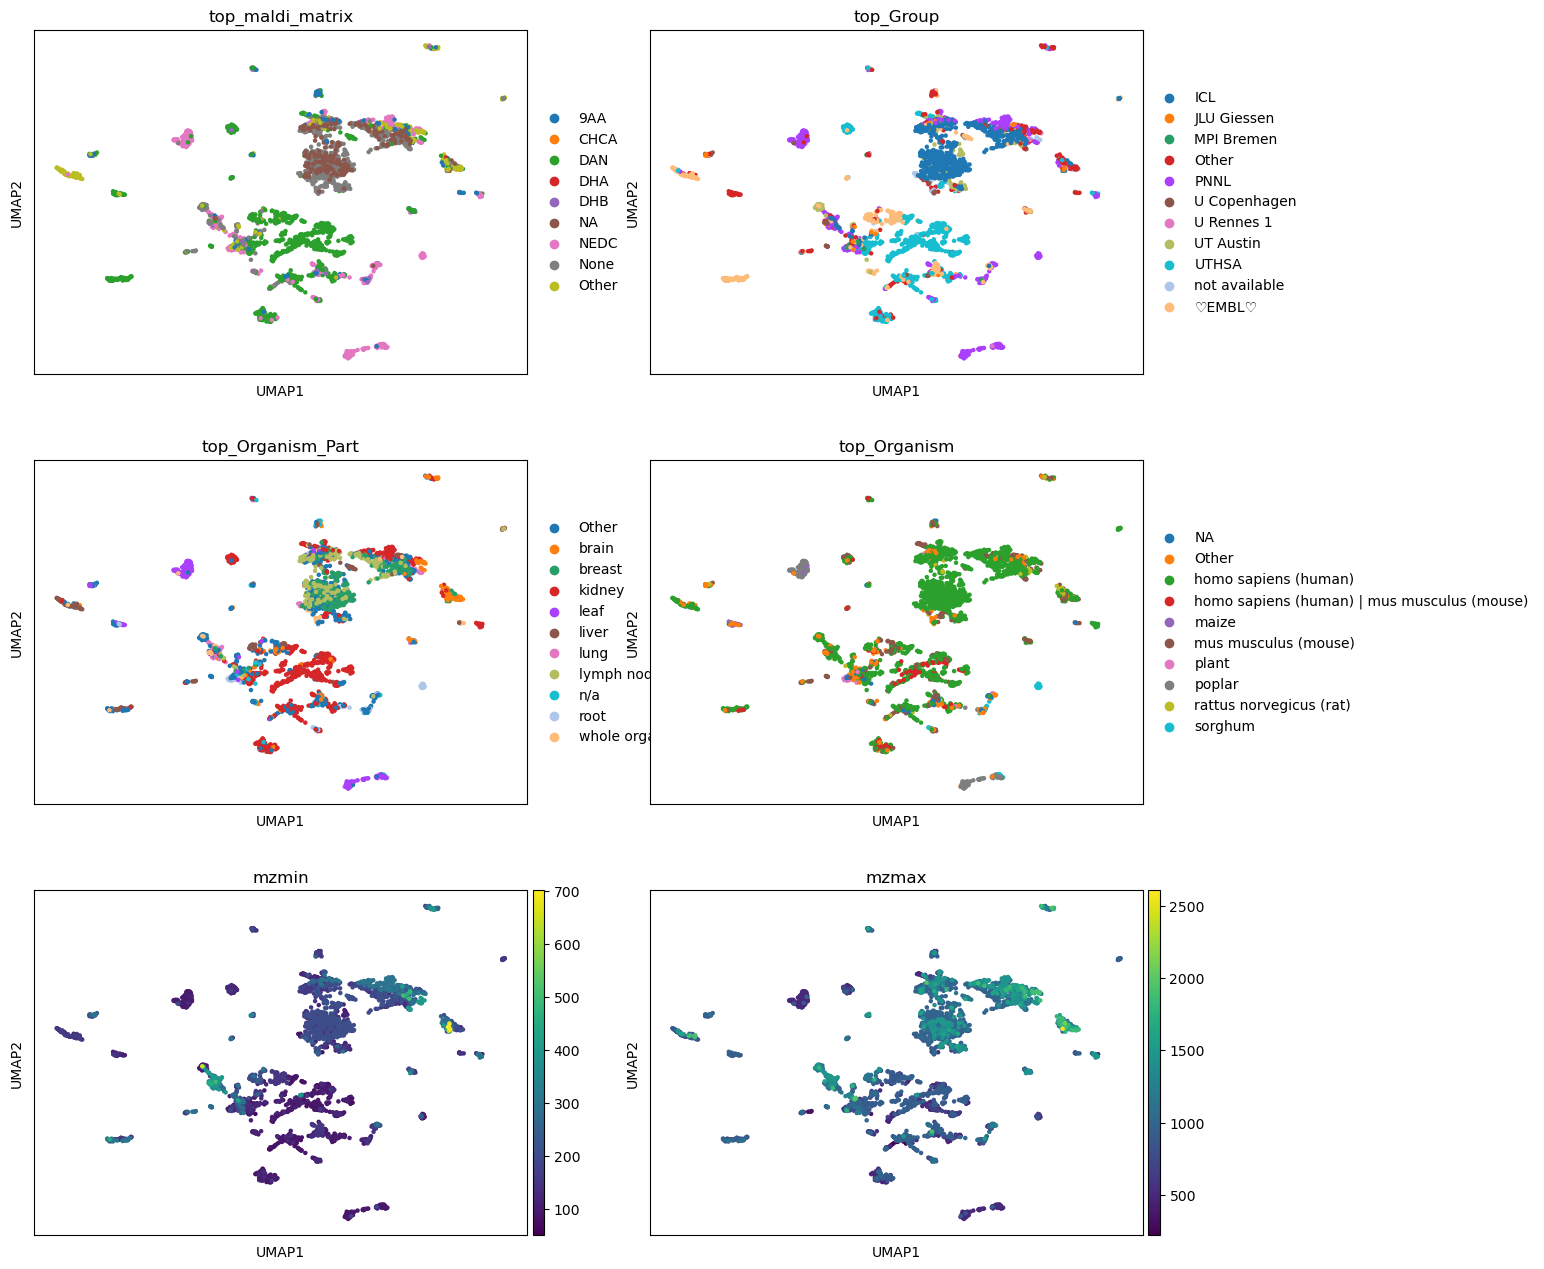

In [88]:
sc.pl.umap(adata_neg_harmony, color=['top_maldi_matrix', 'top_Group', 'top_Organism_Part', 'top_Organism', 'mzmin', 'mzmax'], ncols=2)